In [1]:
from glob import glob
from xml.etree import cElementTree as ElementTree
from utility import *
import sys, json, os
from tqdm import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pickle
%matplotlib inline

In [2]:
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# sns.set(style="whitegrid")
# sns.set_context("paper")
# sns.set_context("talk")
sns.set_context("poster", font_scale=1.5)
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [45]:
xml_files = glob('./analysis/*/*.xml')
# Load pdbs that has resolution less than 3 angstroms
with open("high_quality_pdbs.pickle", "rb") as f:
    valid_pdbs = pickle.load(f)

In [46]:
len(valid_pdbs)

131502

In [48]:
print("Number of xml files: {}".format(len(xml_files)))

Number of xml files: 153504


In [55]:
data = []
# angles = defaultdict(list)
# distances = defaultdict(list)

for _file in tqdm_notebook(xml_files):
    # Get the pdbid
    pdbid = os.path.split(_file)[0]
    pdbid = pdbid.split('/')[2]
    if pdbid not in valid_pdbs: continue

    # Parse the xml file
    tree = ElementTree.parse(_file)
    root = tree.getroot()
    xmldict = XmlDictConfig(root)

    #_dict = {}
    if 'bindingsite' in xmldict.keys():
        d = xmldict['bindingsite']
        if 'interactions' in d.keys():
            d = d['interactions']
            
            # Check pi-interaction
            if d.get('pi_stacks', None) is not None:
                for val in d['pi_stacks'].values():
                    if isinstance(val, dict):
                        data.append([pdbid, 'pi_stacking', val['restype'], float(val['centdist']), float(val['angle']), val['type']])
#                         distances[val['restype']].append(float(val['centdist']))
#                         angles[val['restype']].append(float(val['angle']))
                        #_dict['pi'] = [val['resnr'], val['restype'], float(val['centdist']), float(val['angle']), val['type']]
                    if isinstance(val, list):
                        #_dict['pi'] = []
                        for item in val:
                            data.append([pdbid, 'pi_stacking', item['restype'], float(item['centdist']), float(item['angle']), item['type']])
#                             distances[item['restype']].append(float(item['centdist']))
#                             angles[item['restype']].append(float(item['angle']))
                            #_dict['pi'].append([item['resnr'], item['restype'], float(item['centdist']), float(item['angle']), item['type']])

            if d.get('pi_cation_interactions', None) is not None:
                for cation_interaction in d['pi_cation_interactions'].values():
                    if isinstance(cation_interaction, dict):
                        data.append([pdbid, 'pi_cation', cation_interaction['restype'], float(cation_interaction['dist']), None, None])
                        #_dict['pi_cation'] = [cation_interaction['resnr'], cation_interaction['restype'], float(cation_interaction['dist'])]
                    if isinstance(cation_interaction, list):
                        #_dict['pi_cation'] = []
                        for item in cation_interaction:
                            data.append([pdbid, 'pi_cation', item['restype'], float(item['dist']), None, None])
                            #_dict['pi_cation'].append([item['resnr'], item['restype'], float(item['dist'])])
    
    #if len(_dict) > 0: dictionary[pdbid] = _dict

In [56]:
data_df = pd.DataFrame.from_records(data, columns=['pdbid', 'int_type', 'residue', 'distance', 'angle', 'stack_type'])
print("Dataset length: {}".format(len(data_df)))
data_df.head()

Dataset length: 22189


,pdbid,int_type,residue,distance,angle,stack_type
0,pdb3bmc,pi_stacking,HIS,4.38,16.93,P
1,pdb6bw2,pi_stacking,PHE,5.25,80.37,T
2,pdb6bw2,pi_stacking,PHE,4.82,89.86,T
3,pdb1bzc,pi_stacking,TYR,3.92,21.79,P
4,pdb2bs0,pi_stacking,TYR,3.79,6.85,P


In [6]:
data_df.groupby('int_type').count()

,pdbid,residue,distance,angle,stack_type
int_type,,,,,
pi_cation,5532,5532,5532,0,0
pi_stacking,16656,16656,16656,16656,16656


In [7]:
data_df.groupby('pdbid').count()

,int_type,residue,distance,angle,stack_type
pdbid,,,,,
pdb10mh,4,4,4,4,4
pdb11ba,1,1,1,1,1
pdb121p,2,2,2,2,2
pdb13gs,1,1,1,1,1
pdb1a00,1,1,1,1,1
...,...,...,...,...,...
pdb8gep,2,2,2,0,0
pdb8mht,4,4,4,4,4
pdb9aat,2,2,2,2,2


In [3]:
# data_df = pd.read_csv('data.csv')
# data_df.to_csv('data.csv', index=False)
data_df = data_df[data_df.residue != 'CSM']

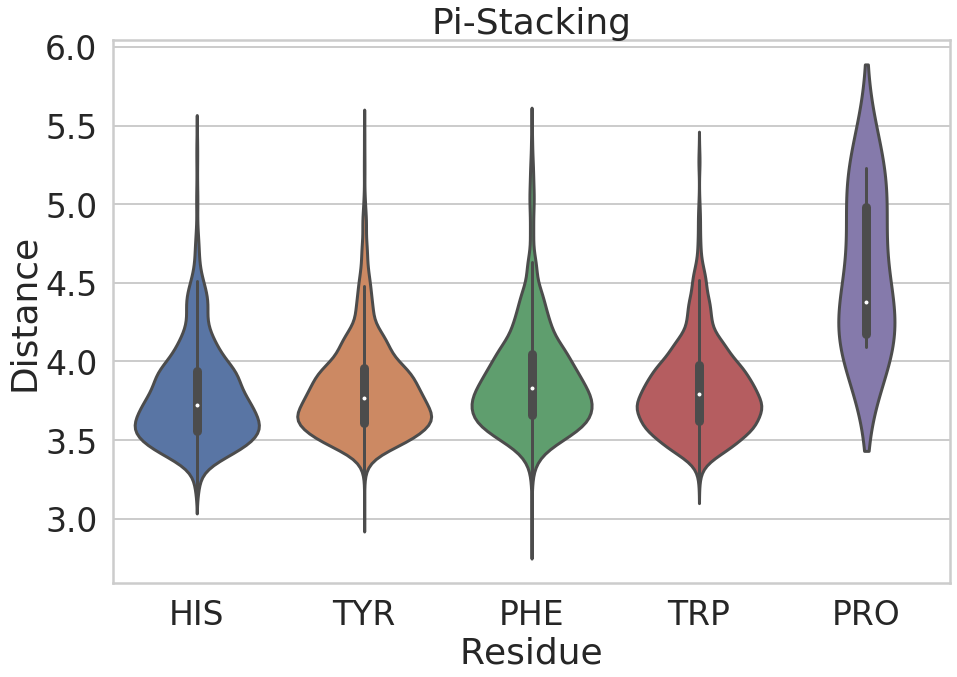

In [61]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="residue", y="distance", data=data_df[data_df.stack_type=='P'])
ax.set_title('Pi-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Distance')
fig.savefig('distance_violin_p-stacking.png', dpi=300)

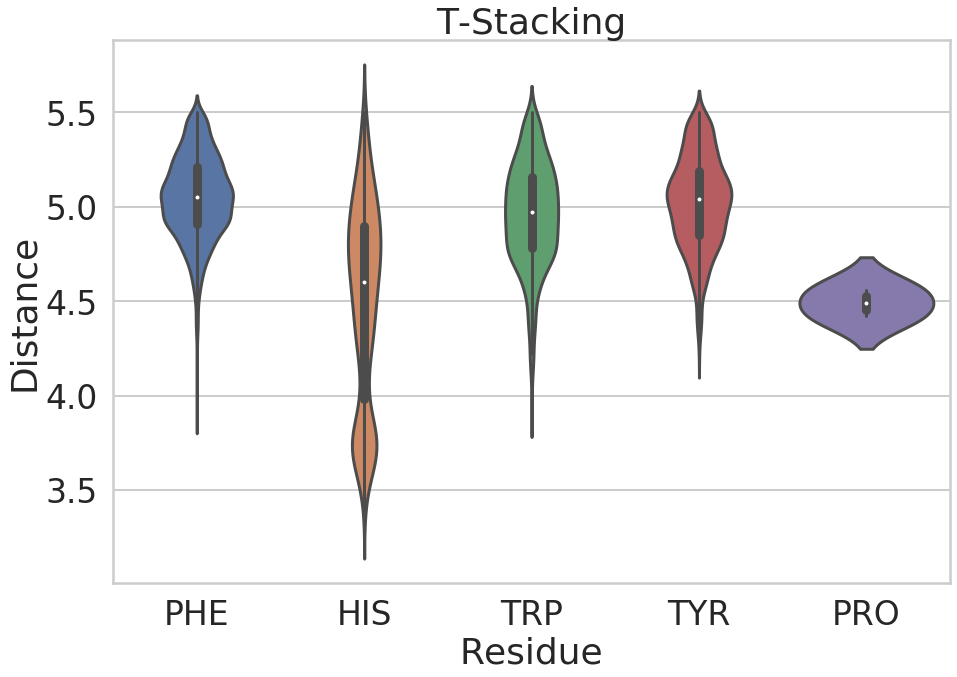

In [62]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="residue", y="distance", data=data_df[data_df.stack_type=='T'])
ax.set_title('T-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Distance')
fig.savefig('distance_violin_t-stacking.png', dpi=300)

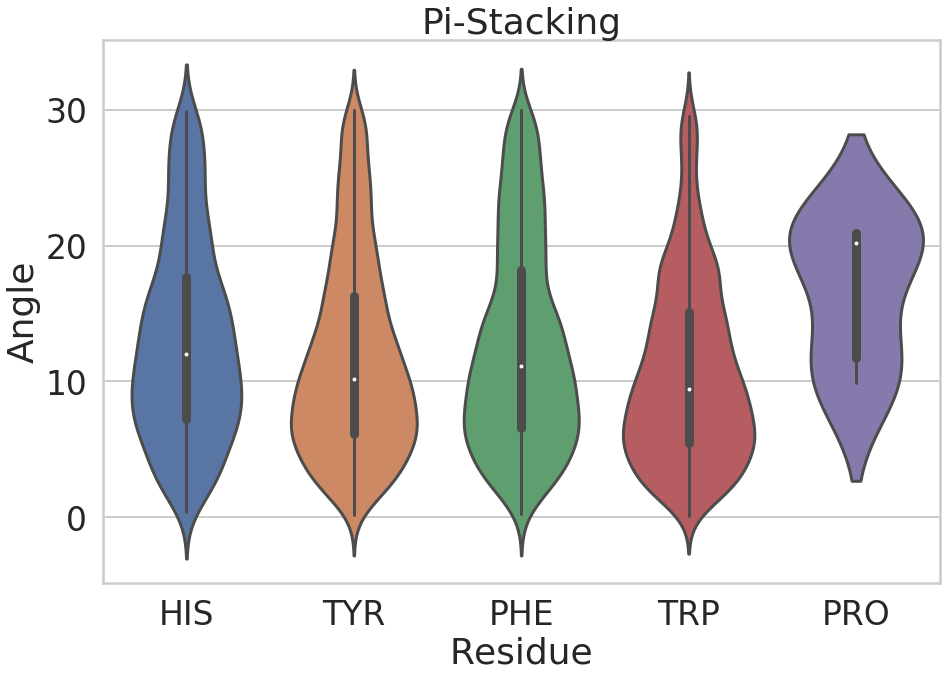

In [63]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="residue", y="angle", data=data_df[data_df.stack_type=='P'])
ax.set_title('Pi-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Angle')
fig.savefig('angle_violin_p-stacking.png', dpi=300)

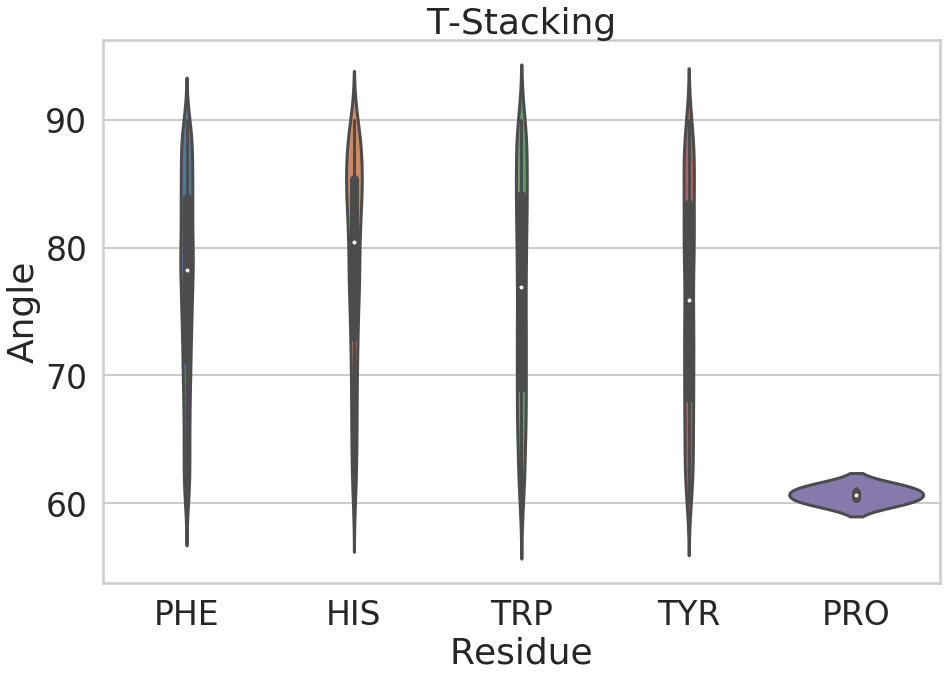

In [65]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="residue", y="angle", data=data_df[data_df.stack_type=='T'])
ax.set_title('T-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Angle')
fig.savefig('angle_violin_t-stacking.png', dpi=300)

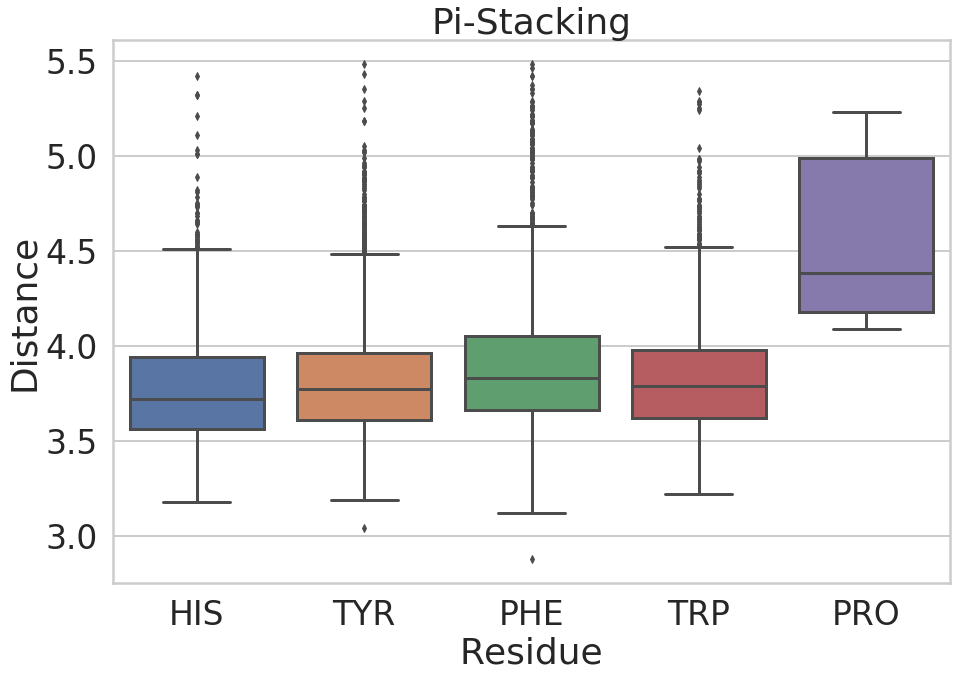

In [66]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x="residue", y="distance", data=data_df[data_df.stack_type=='P'])
ax.set_title('Pi-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Distance')
fig.savefig('distance_boxplot_p-stacking.png', dpi=300)

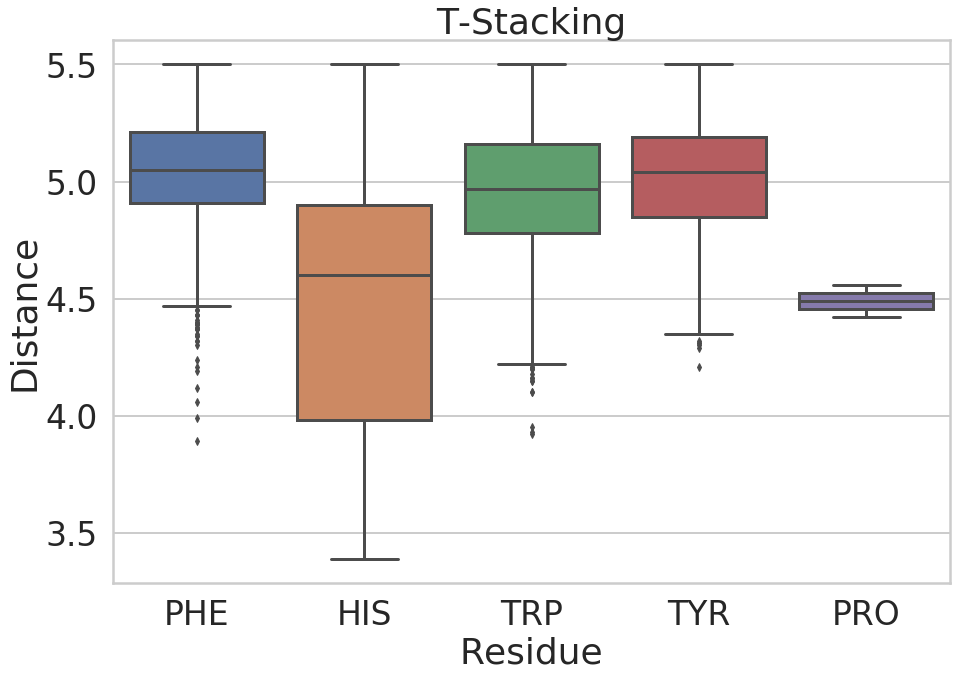

In [67]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x="residue", y="distance", data=data_df[data_df.stack_type=='T'])
ax.set_title('T-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Distance')
fig.savefig('distance_boxplot_t-stacking.png', dpi=300)

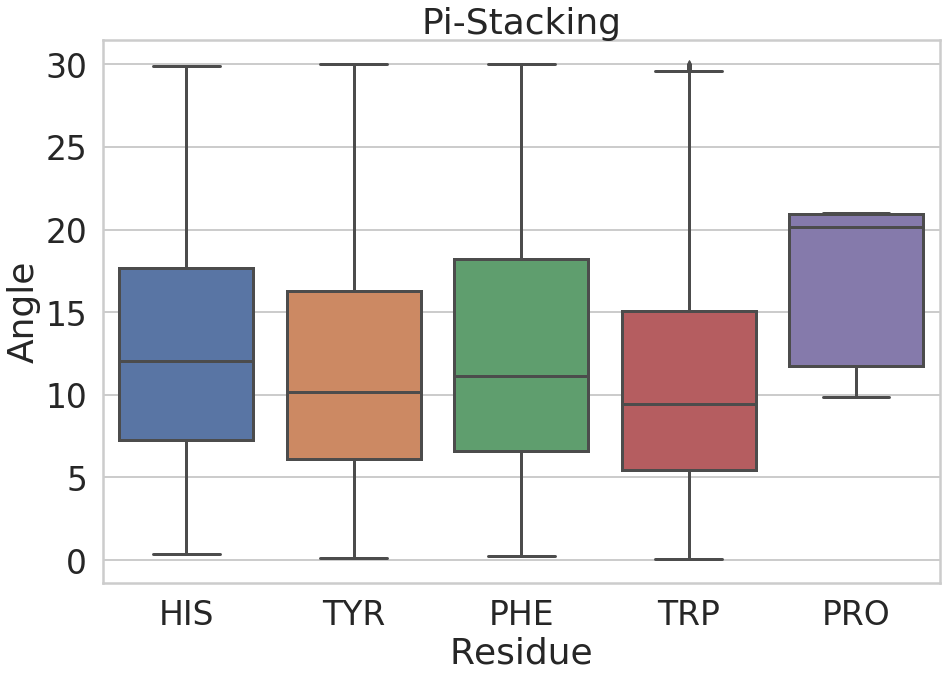

In [68]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x="residue", y="angle", data=data_df[data_df.stack_type=='P'])
ax.set_title('Pi-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Angle')
fig.savefig('angle_boxplot-p_stacking.png', dpi=300)

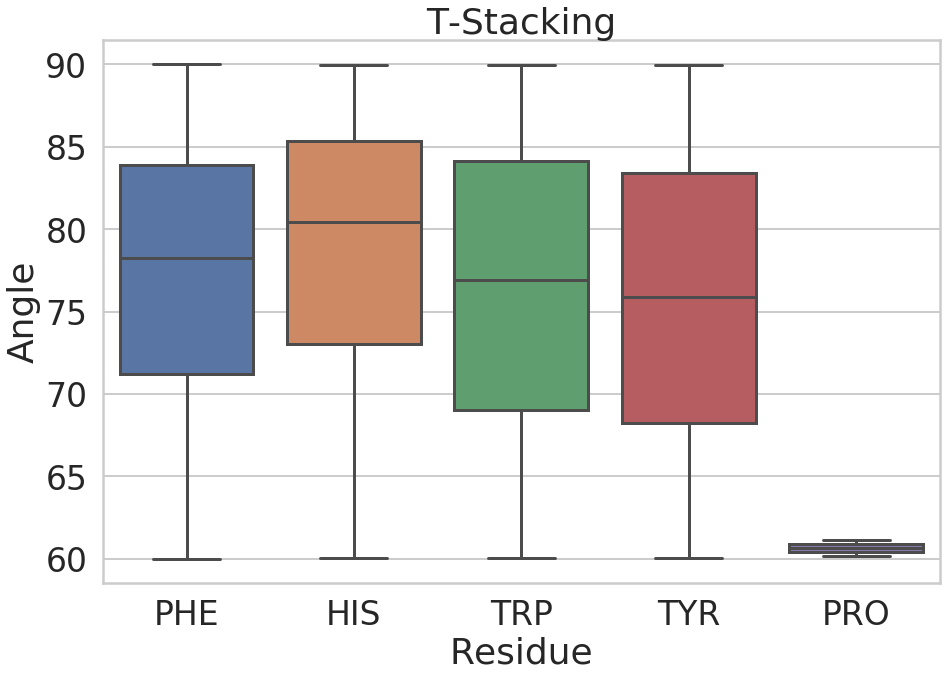

In [69]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x="residue", y="angle", data=data_df[data_df.stack_type=='T'])
ax.set_title('T-Stacking')
ax.set_xlabel('Residue')
ax.set_ylabel('Angle')
fig.savefig('angle_boxplot-t_stacking.png', dpi=300)